# 蔵元モデル
## 蔵元モデルのダイナミクス
**蔵本モデル（Kuramoto model）**とは、主に多数の自励振動子（位相振動子）が相互作用によって同期現象を起こす仕組みを簡明に捉えた理論モデルです。

グラフ$G$上の蔵元モデルのダイナミクスは
$$
  \mathrm{d} \theta_i =   \left(\omega  +  \frac{K}{|N_i|} \sum_{j \in N_i}\sin (\theta_i - \theta_j\right)\mathrm{d}t + \sqrt{2D} \mathrm{d} \xi
$$
となる。
ここで、クラフのノード数$i$の隣接ノードの集合を$N_i$,グラフ間の結合力を$K$、$\xi_i$はウィナー過程である。

同期現象の指針として、秩序パラメーター$z$の振幅$R$を用いて、評価されています。
$$
z \triangleq  R e^{i\Theta}= \frac{1}{N}\sum_{j = 1}^N e^{i \theta_j}
$$
ここで、$\Theta$は、各ノードの角度$\theta_i$上の平均角度とする。 
$R$は0から1の間を取り、$R$が1に近いほど同期　、$R$が0に近いほど非同期と呼ばれる。

一般にグラフ$G$の次元が発散すると、ある結合力の切り替え点$K_c = f(D)$が存在し、
$K>K_c$ならば$R$は1に$K<K_c$ならば$R$は0に収束する。
そのため$K=K_c$において相転移が起こっていると言われている。

グラフ$G$が完全グラフの際には、切り替え点$K_c$が解析的に証明されており、
$$
 K_c = 2D
$$
のとき、相転移することが知られている。

本コードの構成は、
1. 相転移の確認コード
2. 時系列データの作成用コード

に分類される。
以下では、それぞれについて解説する。

## Requirement
```code
networkx
sdeint
tqdm
```


In [ ]:
!pip install networkx sdeint tqdm

## 蔵元モデルのクラス
以下をコピーして使ってください。

In [78]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import sdeint
from tqdm import tqdm

def nx_show(_G):
    # グラフを描画
    pos = nx.spring_layout(_G, seed=42)  # レイアウトを指定（seedで乱数の初期値を固定）
    nx.draw(_G, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=800)
    plt.show()
    return

class KuramotoDynamics():
    def __init__(self,K = 0.05,D =  0.5,G = None,omega = 0.0):
        #
        self.omega = omega
        self.sigma = np.sqrt(2*D)
        self.K = K
        if G is None:
            G = nx.complete_graph(10)
        self.G = G
        A = nx.adjacency_matrix(G) 
        D_inv = np.diag(1/A.sum(axis=1))
        self.A_tilde =  D_inv @ A
        self.n = A.shape[0]
        return


    def f(self, theta,t):
        # on Ito statistic ODE : dx = f(x,t)dt + g(x,t)dw 
        
        x =  theta.reshape(self.n,1)
        del_x = x @ np.ones((1,self.n)) -  np.ones((self.n,1)) @ x.T
        return self.omega - self.K*np.sum(self.A_tilde * np.sin(del_x),1)
    def g(self,theta,t):
        return self.sigma * np.eye(self.n)
    
    def generate(self,times = None,x0 = None):
        if x0 is None:
            x0 = 4 * np.pi * np.random.rand(self.n) - 2 * np.pi
        if times is None:
            times = np.linspace(0,100,1001)
        self.xt = sdeint.itoEuler(self.f, self.g, x0, times)
        return 
    def mean_amplitude(self):
        #input :  
        #- xt :shap[time_length,dim]
        #output :  
        #- R : scalar
        self.R = np.abs(np.exp(1j * self.xt).mean(1)[self.xt.shape[0]//2:]).mean()
        return 
    def postprosessing_onT1(self):
        self.xt_T1= (self.xt / (2 * np.pi)) %1
        return
        

class KuramotoPhaseTransition():
    # Check Phase Transition of Kuramoto Dynamics
    def __init__(self,G,D =  0.5):
        self.G = G
        self.D = D
        return 
    def calc_RK(self,Ks = None):
        self.Ra = 2*self.D 
        if Ks is None:
            Ks = self.Ra * (2 ** np.linspace(-3,3,41))
        self.Ks = Ks
        self.Rs =  np.zeros(Ks.shape[0])
        
        for i in tqdm(range(Ks.shape[0])):
            dynamics = KuramotoDynamics(Ks[i],self.D,self.G)
            dynamics.generate(np.linspace(0,1000,10001))
            dynamics.mean_amplitude()
            self.Rs[i] = dynamics.R
        return
        
    def plot_RK(self):
        plt.title(f"Phase Change trajectory : D={self.D}, Theoretical point K ={self.Ra}")
        plt.plot(sim.Ks,sim.Rs)
        plt.xscale('log')
        plt.xlabel('K')
        plt.ylabel('R')
        plt.xticks(self.Ra*(2.0**np.arange(-3,4)),self.Ra*(2.0**np.arange(-3,4)))
        plt.show()
        return

class MakeKuramotoDataset():
    def __init__(self,N,K = 0.05,D =  0.5,G = None,omega = 0.0):
        # N : sample size 
        # K : Spring Constant
        # D : Noise std
        # G : Graph type
        # omega : the bias of angular velocity
        self.N = N
        self.dynamics = KuramotoDynamics(K,D,G,omega)
        self.n = self.dynamics.n
        return 
    def generate(self,times = None,x0 = None):
        # input :
        #  times : shape[T]
        #  x0 : shape[N,n]
        # output : 
        #  x_data : shape[N,T,n]
        if x0 is None:
            x0 = 4 * np.pi * np.random.rand(self.N,self.n) - 2 * np.pi
        if times is None:
            times = np.linspace(0,100,1001)
        self.x0 = x0
        self.times = times
        self.T = times.shape[0]
        self.x_data = np.zeros((self.N,self.T,self.n))
        for i in tqdm(range(self.N)):
            self.dynamics.generate(times,x0[i])
            self.x_data[i] = self.dynamics.xt
        return
    def normalization(self,type = None):
        if type == 'std':
            self.mu = self.x_data.mean()
            self.std = self.x_data.std()
            self.x_data = (self.x_data - self.mu) / self.std
            return
        elif type == 'T1':
            self.x_data =(self.x_data / (2 * np.pi)) %1
            return
        elif type is None:
            return
        else:
            print('Error: set normalization type in [None,std,T1]')
            return -1
    def save(self,filename , type = 'numpy'):
        if type == 'numpy':
            np.save(filename,self.x_data)
        return

## 蔵元モデルの相転移のチェック
以下を実行してください。



100%|███████████████████████████████████████████| 41/41 [00:05<00:00,  7.76it/s]


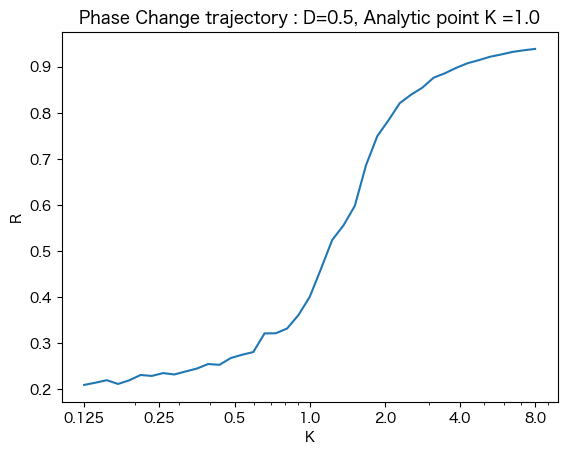

In [77]:
# グラフの定義
n = 20
G = nx.erdos_renyi_graph(n,0.25)
#　　分散のパラメータ
D =  0.5
# PhaseTransition用のクラスの定義　
sim = KuramotoPhaseTransition(G,D)
# Kの変化に取るRの値の変化を計算
sim.calc_RK()
# plot
sim.plot_RK()

## データセットの生成
上のテストをパラメータの設定を行い、データの生成を行ってください。


例えば、以下の実験が望ましいでしょう。

|Experiment_ID|　Number of dataset (N)|Graph type|Dimention of Graph(n)|Spring Coefficient(K)|Noise(D)|Normalizing|
|--|--|--|--|--|--|--|
|1|1000|erdos_renyi(p=0.25)|10|1.25|0.5|std|
|2|1000|erdos_renyi(p=0.25)|10|0.75|0.5|std|
|3|1000|erdos_renyi(p=0.25)|100|1.25|0.5|std|
|4|1000|erdos_renyi(p=0.25)|100|0.75|0.5|std|
|3|1000|erdos_renyi(p=0.25)|100|1.25|0.5|T1|
|4|1000|erdos_renyi(p=0.25)|100|0.75|0.5|T1|
|5|1000|erdos_renyi(p=0.25)|1000|1.25|0.5|std|
|6|1000|erdos_renyi(p=0.25)|1000|0.75|0.5|std|



In [79]:
# グラフの定義
n = 10
G = nx.erdos_renyi_graph(n,0.25)
#　　パラメータ
K =  1.25
D =  0.5
# データセット
N = 1000

# クラスの定義
mkData =  MakeKuramotoDataset(N,K,D,G)
# データの生成
mkData.generate()
# Normalization
mkData.normalization('std')
# データの保存
mkData.save('Experiment_1',type = 'numpy')


100%|██████████████████████████████████████| 1000/1000 [00:09<00:00, 103.94it/s]


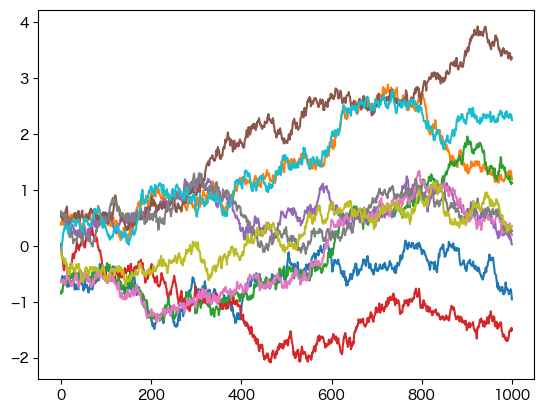

In [81]:
#チェック方法： 0番目のデータをプロット
plt.plot(mkData.x_data[0])
plt.show()


## 参考文献： 
### 完全グラフで証明を行っている中尾先生の記事：
https://www.jstage.jst.go.jp/article/sicejl/55/4/55_335/_article/-char/ja/

### Networkxのランダムネットワーク：
1. [erdos_renyi_graph](https://networkx.org/documentation/stable/reference/generated/networkx.generators.random_graphs.erdos_renyi_graph.html)
2. [全結合グラフ](https://networkx.org/documentation/stable/reference/generated/networkx.generators.classic.complete_graph.html)
3. [格子グラフ](https://networkx.org/documentation/stable/reference/generated/networkx.generators.lattice.grid_2d_graph.html)

## ライセンス
好きに使え

## 連絡先 
yuji.0001-------change to at mark------gmail.com 